In [409]:
# 필요 패키지 로드
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import patches
%matplotlib inline
import os
import numpy as np
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols 
from statsmodels.api import OLS, add_constant

In [410]:
Basic_dir = os.path.dirname(os.path.dirname(os.path.realpath('EDA.ipynb')))
PATH = Basic_dir + '\\Data\\Data(WineQ_B)\\'
os.listdir(PATH)

['sample_submission(KNN01).csv',
 'sample_submission(로지스틱 회귀).csv',
 'sample_submission.csv',
 'test.csv',
 'train.csv']

In [411]:
# 데이터 로드
train = pd.read_csv(PATH + '\\train.csv')
test = pd.read_csv(PATH + '\\test.csv')
print(train.columns)
train.head()

Index(['id', 'fixed acidity', 'volatile acidity', 'citric acid',
       'residual sugar', 'chlorides', 'free sulfur dioxide',
       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'type',
       'quality'],
      dtype='object')


,id,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type,quality
0,1,8.0,0.18,0.37,1.3,0.040,15.0,96.0,0.99120,3.06,0.61,12.1,white,6
1,2,7.5,0.38,0.29,4.9,0.021,38.0,113.0,0.99026,3.08,0.48,13.0,white,7
2,3,6.1,0.27,0.33,2.2,0.021,26.0,117.0,0.98860,3.12,0.30,12.5,white,6
3,4,6.4,0.32,0.50,10.7,0.047,57.0,206.0,0.99680,3.08,0.60,9.4,white,5
4,5,8.4,0.37,0.43,2.3,0.063,12.0,19.0,0.99550,3.17,0.81,11.2,red,7


In [412]:
df = train.drop(['id'], axis = 1).copy()
# 범주형 변수 인코딩 : 와인 종류 - 0 : 화이트, 1: 레드
df.type = np.where(df.type == 'white', 0, 1)
test.type = np.where(test.type == 'white', 0, 1)
df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'type', 'quality'],
      dtype='object')

In [413]:
x_list = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
          'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
          'pH', 'sulphates', 'alcohol']
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type,quality
0,8.0,0.18,0.37,1.30,0.040,15.0,96.0,0.99120,3.06,0.61,12.1,0,6
1,7.5,0.38,0.29,4.90,0.021,38.0,113.0,0.99026,3.08,0.48,13.0,0,7
2,6.1,0.27,0.33,2.20,0.021,26.0,117.0,0.98860,3.12,0.30,12.5,0,6
3,6.4,0.32,0.50,10.70,0.047,57.0,206.0,0.99680,3.08,0.60,9.4,0,5
4,8.4,0.37,0.43,2.30,0.063,12.0,19.0,0.99550,3.17,0.81,11.2,1,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3226,6.4,0.16,0.31,5.30,0.043,42.0,157.0,0.99455,3.35,0.47,10.5,0,5
3227,6.4,0.18,0.28,17.05,0.047,53.0,139.0,0.99724,3.25,0.35,10.5,0,6
3228,6.0,0.28,0.25,1.80,0.042,8.0,108.0,0.99290,3.08,0.55,9.0,0,5
3229,7.7,0.28,0.29,6.90,0.041,29.0,163.0,0.99520,3.44,0.60,10.5,0,6


In [414]:
# 순위변수(품질)와 연속형변수(x_list에 해당하는 자료들)을 분석하기 위해 스피어만 상관계수 사용
# 품질을 연속형으로 보면 회귀 및 피어슨 상관계수분석 가능
# p-value가 0.05 이하인 변수들은 제외
from scipy import stats
val_list = []
for col in x_list:
    if stats.spearmanr(df[col], df.quality)[1] < 0.05:
        val_list.append(col)
        print(f'{col} : {round(stats.spearmanr(df[col], df.quality)[0], 3)}, {round(stats.spearmanr(df[col], df.quality)[1], 5)}')
val_list = val_list + ['type']

fixed acidity : -0.109, 0.0
volatile acidity : -0.254, 0.0
citric acid : 0.08, 1e-05
chlorides : -0.286, 0.0
free sulfur dioxide : 0.082, 0.0
total sulfur dioxide : -0.058, 0.00092
density : -0.329, 0.0
pH : 0.044, 0.01194
alcohol : 0.449, 0.0


In [415]:
# 변형 - 낮은 상관계수를 가진 변수들 제거
val_list.remove('citric acid')
val_list.remove('free sulfur dioxide')
val_list.remove('total sulfur dioxide')
val_list.remove('pH')
print(val_list)

['fixed acidity', 'volatile acidity', 'chlorides', 'density', 'alcohol', 'type']


In [416]:
df_train01 = df[val_list + ['quality']].copy()
df_train01.head()

,fixed acidity,volatile acidity,chlorides,density,alcohol,type,quality
0,8.0,0.18,0.040,0.99120,12.1,0,6
1,7.5,0.38,0.021,0.99026,13.0,0,7
2,6.1,0.27,0.021,0.98860,12.5,0,6
3,6.4,0.32,0.047,0.99680,9.4,0,5
4,8.4,0.37,0.063,0.99550,11.2,1,7


In [417]:
df_test01 = test[val_list].copy()
df_test01

,fixed acidity,volatile acidity,chlorides,density,alcohol,type
0,7.3,0.31,0.032,0.99244,11.1,0
1,8.7,0.70,0.226,0.99910,9.0,1
2,6.9,0.63,0.076,0.99522,10.8,1
3,6.3,0.23,0.043,0.99542,9.1,0
4,6.9,0.54,0.077,0.99870,9.4,1
...,...,...,...,...,...,...
3226,7.1,0.32,0.050,0.99800,8.8,0
3227,5.6,0.28,0.034,0.99144,12.1,0
3228,7.3,0.31,0.041,0.99770,8.6,0
3229,5.2,0.34,0.031,0.99076,12.5,0


In [418]:
# 데이터 스케일링(정규화)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_train01.iloc[:, :5] = scaler.fit_transform(df_train01.iloc[:, :5])
df_train01
df_test01.iloc[:, :5] = scaler.fit_transform(df_test01.iloc[:, :5])
df_test01

,fixed acidity,volatile acidity,chlorides,density,alcohol,type
0,0.306306,0.184,0.038270,0.229176,0.516667,0
1,0.432432,0.496,0.361065,0.516616,0.166667,1
2,0.270270,0.440,0.111481,0.349158,0.466667,1
3,0.216216,0.120,0.056572,0.357790,0.183333,0
4,0.270270,0.368,0.113145,0.499353,0.233333,1
...,...,...,...,...,...,...
3226,0.288288,0.192,0.068220,0.469141,0.133333,0
3227,0.153153,0.160,0.041597,0.186016,0.683333,0
3228,0.306306,0.184,0.053245,0.456193,0.100000,0
3229,0.117117,0.208,0.036606,0.156668,0.750000,0


In [419]:
# 품질과 와인종류간 연관성 테스트 
# 크루스칼 왈리스(독립변수 집단 중 하나라도 정규성 가정이 깨질때 사용 / 비모수적 방법) / ANOVA 분산분석(모수적 방법)
import statsmodels.api as sm
from statsmodels.formula.api import ols
# 분산분석시 하는 것들
# 1. 정규성 검정
# p-value가 0.05보다 작으므로 귀무가설 기각 - 정규분포를 따르지 않는다. - 크루스칼 왈리스 사용
print(stats.shapiro(df_train01[df_train01['type'] == 0].quality)) # 앞의 값이 통계량 / 뒤의 값이 p-value(0.05보다 크면 귀무가설[정규분포를 따른다] 기각)
print(stats.shapiro(df_train01[df_train01['type'] == 1].quality)) # 앞의 값이 통계량 / 뒤의 값이 p-value(0.05보다 크면 귀무가설[정규분포를 따른다] 기각)

# 2. 등분산성 검정
# p-value가 0.05보다 작으므로 귀무가설 기각불가 - 등분산이다 
print(stats.levene(df_train01[df_train01['type'] == 0].quality,\
                   df_train01[df_train01['type'] == 1].quality)) # 앞의 값이 통계량 / 뒤의 값이 p-value(0.05보다 크면 귀무가설[등분산이다] 기각)

# ANOVA 분산분석
formula = 'quality~type'
model = ols(formula, data = df_train01[['type', 'quality']]).fit()
print('ANOVA 결과', sm.stats.anova_lm(model), sep = '\n')

# 크루스칼 왈리스 순위합 검정
# p-value가 0.05이하이므로 귀무가설(관계가 없다)기각
stats.kruskal(df_train01[df_train01['type'] == 0].quality,\
              df_train01[df_train01['type'] == 1].quality)

# + 이분산을 고려한 분산분석은 welch_anova를 사용한다.
# 독립변수로 1. fixed acidity 2. volatile acidity 3. chlorides 4. density 5. alcohol 6. type만 사용

(0.8806405067443848, 6.8211285607631986e-40)
(0.8489985466003418, 1.3885939491592415e-26)
LeveneResult(statistic=2.2844341277661093, pvalue=0.13077564881090867)
ANOVA 결과
              df       sum_sq    mean_sq          F        PR(>F)
type         1.0    37.628243  37.628243  52.917308  4.345939e-13
Residual  3229.0  2296.065350   0.711076        NaN           NaN


KruskalResult(statistic=54.912671932245594, pvalue=1.260059601804536e-13)

In [420]:
# 클래스 불균형 처리를 해주는 imbalanced-learn를 호출
# 오버 샘플링 시행
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
ros = RandomOverSampler()
ov_data, ov_label = ros.fit_resample(df_train01[val_list].copy(), df_train01[['quality']].copy())
ov_data = pd.DataFrame(ov_data, columns = val_list)
ov_data['quality'] = ov_label
len(df_train01), len(ov_data)

(3231, 7090)

In [421]:
ov_data.quality.value_counts()

6    1418
7    1418
5    1418
8    1418
4    1418
Name: quality, dtype: int64

In [422]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(ov_data[val_list], ov_data[['quality']], test_size = 0.1, stratify = ov_data.quality, random_state = 7)

In [423]:
# 로지스틱 회귀분석 테스트
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)

C:\Users\Bestc\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Bestc\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [424]:
# 성능평가(훈련)
print(confusion_matrix(y_train, lr.predict(X_train)))
print(classification_report(y_train, lr.predict(X_train)))

[[631 279 178  98  91]
 [255 688 183  81  69]
 [109 371 312 200 284]
 [ 58 156 135 346 581]
 [ 76 129 174 233 664]]
              precision    recall  f1-score   support

           4       0.56      0.49      0.52      1277
           5       0.42      0.54      0.47      1276
           6       0.32      0.24      0.28      1276
           7       0.36      0.27      0.31      1276
           8       0.39      0.52      0.45      1276

    accuracy                           0.41      6381
   macro avg       0.41      0.41      0.41      6381
weighted avg       0.41      0.41      0.41      6381



In [425]:
# 성능평가(테스트)
from sklearn.metrics import accuracy_score
y_pred = lr.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
# print(classification_report(y_test, y_pred))
print(f'Accuracy : {accuracy*100}')
print(confusion_matrix(y_test, lr.predict(X_test)))
print(classification_report(y_test, lr.predict(X_test)))

Accuracy : 41.889985895627646
[[69 37 15 10 10]
 [30 75 22  7  8]
 [12 41 29 28 32]
 [10 20 19 40 53]
 [ 9 15 16 18 84]]
              precision    recall  f1-score   support

           4       0.53      0.49      0.51       141
           5       0.40      0.53      0.45       142
           6       0.29      0.20      0.24       142
           7       0.39      0.28      0.33       142
           8       0.45      0.59      0.51       142

    accuracy                           0.42       709
   macro avg       0.41      0.42      0.41       709
weighted avg       0.41      0.42      0.41       709



In [426]:
lr.predict(df_test01)

array([8, 5, 6, ..., 5, 8, 8], dtype=int64)

In [427]:
# 정답파일 작성
predict = pd.read_csv(PATH + '\\sample_submission.csv')
len(predict), len(test)
predict.quality = lr.predict(df_test01)
predict.to_csv(PATH + 'sample_submission(로지스틱 회귀).csv', index = False)
pd.read_csv(PATH + 'sample_submission(로지스틱 회귀).csv').head()

,id,quality
0,1,8
1,2,5
2,3,6
3,4,6
4,5,5


# ------------------------------------------------------------------------------

In [428]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(ov_data[val_list], ov_data[['quality']], test_size = 0.1, stratify = ov_data.quality, random_state = 7)

In [429]:
val_list

['fixed acidity',
 'volatile acidity',
 'chlorides',
 'density',
 'alcohol',
 'type']

In [430]:
# KNN 모델
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [431]:
# 정확도 테스트(훈련데이터 셋)
from sklearn.metrics import accuracy_score
n = 7
neigh_n = KNeighborsClassifier(n_neighbors = n, weights = 'distance')
neigh_n.fit(X_train, list(y_train.quality))
y_pred = neigh_n.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)
print(classification_report(y_train, y_pred))
print(f'Accuracy : {accuracy*100}')

              precision    recall  f1-score   support

           4       1.00      1.00      1.00      1277
           5       1.00      1.00      1.00      1276
           6       1.00      1.00      1.00      1276
           7       1.00      1.00      1.00      1276
           8       1.00      1.00      1.00      1276

    accuracy                           1.00      6381
   macro avg       1.00      1.00      1.00      6381
weighted avg       1.00      1.00      1.00      6381

Accuracy : 100.0


In [432]:
# 정확도 테스트(테스트데이터 셋)
from sklearn.metrics import accuracy_score
n = 7
neigh_n = KNeighborsClassifier(n_neighbors = n, weights = 'distance')
neigh_n.fit(X_train, list(y_train.quality))
y_pred = neigh_n.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))
print(f'Accuracy : {accuracy*100}')

              precision    recall  f1-score   support

           4       0.88      1.00      0.94       141
           5       0.78      0.82      0.80       142
           6       0.78      0.42      0.55       142
           7       0.77      0.92      0.84       142
           8       0.92      1.00      0.96       142

    accuracy                           0.83       709
   macro avg       0.83      0.83      0.82       709
weighted avg       0.83      0.83      0.82       709

Accuracy : 83.07475317348378


In [439]:
neigh_n.predict(df_test01)

array([7, 5, 4, ..., 5, 8, 4])

In [441]:
# 정답파일 작성
predict = pd.read_csv(PATH + '\\sample_submission.csv')
len(predict), len(test)
predict.quality = neigh_n.predict(df_test01)
predict.to_csv(PATH + 'sample_submission(KNN01).csv', index = False)
pd.read_csv(PATH + 'sample_submission(KNN01).csv').head()

,id,quality
0,1,7
1,2,5
2,3,4
3,4,6
4,5,6


In [448]:
# 실제 데이콘 데이터는 훈련셋과 테스트 셋이 미리 나뉘어져 있음. --> 데이터 분할없이 모델 학습 실시후 정확도 예측 실시
# 정확도 테스트
from sklearn.metrics import accuracy_score
n = 7
neigh_n = KNeighborsClassifier(n_neighbors = n, weights = 'distance')
neigh_n.fit(ov_data[val_list], list(ov_label.quality))
y_pred = neigh_n.predict(ov_data[val_list])
accuracy = accuracy_score(ov_label, y_pred)
print(classification_report(ov_label, y_pred))
print(f'Accuracy : {accuracy*100}')

              precision    recall  f1-score   support

           4       1.00      1.00      1.00      1418
           5       1.00      1.00      1.00      1418
           6       1.00      1.00      1.00      1418
           7       1.00      1.00      1.00      1418
           8       1.00      1.00      1.00      1418

    accuracy                           1.00      7090
   macro avg       1.00      1.00      1.00      7090
weighted avg       1.00      1.00      1.00      7090

Accuracy : 99.98589562764457


In [449]:
neigh_n.predict(df_test01)

array([7, 5, 4, ..., 5, 7, 4])

In [450]:
# 정답파일 작성
predict = pd.read_csv(PATH + '\\sample_submission.csv')
len(predict), len(test)
predict.quality = neigh_n.predict(df_test01)
predict.to_csv(PATH + 'sample_submission(KNN02).csv', index = False)
pd.read_csv(PATH + 'sample_submission(KNN02).csv').head()

,id,quality
0,1,7
1,2,5
2,3,4
3,4,6
4,5,6


In [454]:
df1 = pd.read_csv(PATH + 'sample_submission(KNN01).csv')
df2 = pd.read_csv(PATH + 'sample_submission(KNN02).csv')
n = 0
for i in range(len(df1)):
    if df1.quality[i] != df2.quality[i]:
        n += 1
n

234

# ------------------------------------------------------------------------------

In [635]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(ov_data[val_list], ov_data[['quality']], test_size = 0.1, stratify = ov_data.quality, random_state = 7)

In [636]:
y_train.quality.to_numpy()

array([4, 8, 7, ..., 5, 6, 4], dtype=int64)

In [637]:
# 학습데이터로 사용하기 위해 pandas파일을 numpy파일로 변환
print(X_train.shape, X_train.to_numpy().shape, X_test.shape, X_test.to_numpy().shape)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.quality.to_numpy()
y_test = y_test.quality.to_numpy()

(6381, 6) (6381, 6) (709, 6) (709, 6)


In [638]:
# 신경망 분류모델 작성
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

# quality가 범주형이므로 범주형으로 변환
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(X_train.shape) 

(6381, 6)


In [639]:
y_train.shape

(6381, 9)

In [ ]:
# 입력데이터의 형태를 반드시 입력해주어야 함
# 차원이 6개 -> input값 일치화
model = Sequential()
model.add(Dense(64, activation = 'relu', input_shape = (6, ))) # 6차원의 데이터를 입력으로 받고, 64개의 출력 가지는 첫번째 Dense층
model.add(Dense(32, activation = 'relu')) # 32개의 출력을 가지는 Dense층
model.add(Dense(9, activation = 'softmax')) # 9개의 출력을 가지는 신경망(마지막은 반드시 y의 변수 종류수와 일치시켜줄 것)

# 학습과정 설정하기
# 옵티마이저 : Adam, 손실함수 : categorical_crossentropy, 모니터링할 평가지표 : acc
model.compile(optimizer=tf.keras.optimizers.Adam(), loss = 'categorical_crossentropy', metrics=[tf.keras.metrics.CategoricalAccuracy()])
model.summary()
# 모델학습하기
history = model.fit(X_train, y_train, epochs = 10000, batch_size = 128, validation_data = (X_test, y_test))

In [645]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])

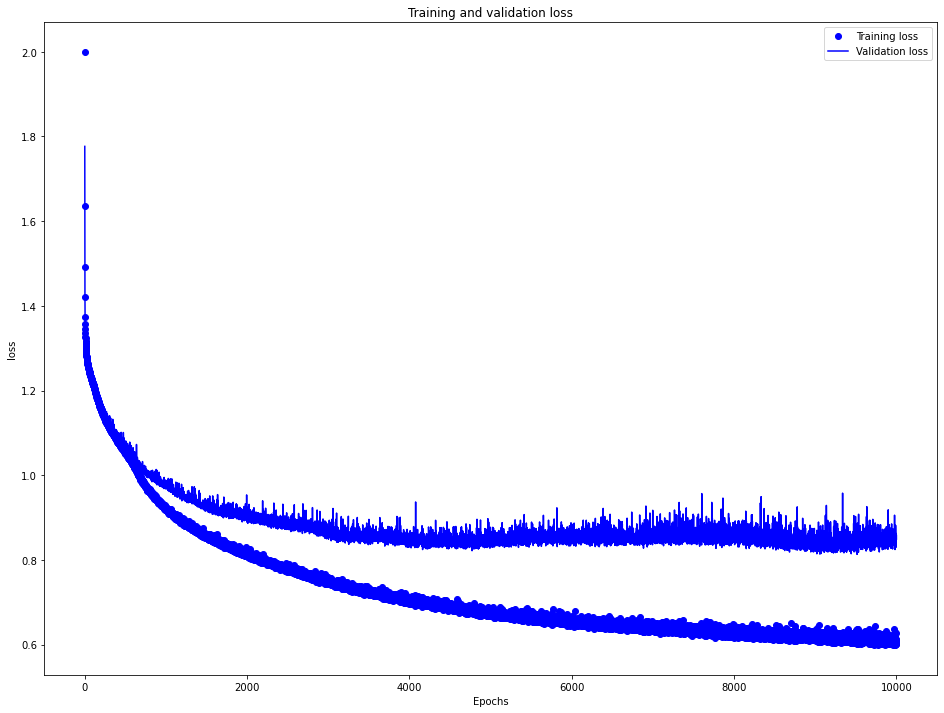

In [643]:
import matplotlib.pyplot as plt
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(loss)+1)
plt.figure(figsize = (16, 12))
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

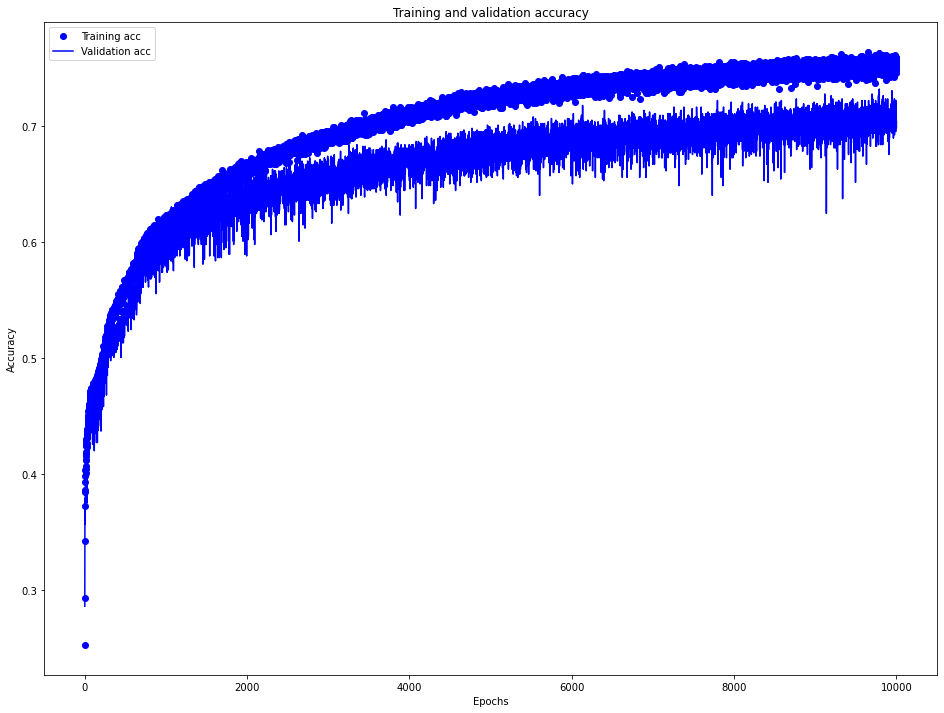

In [646]:
plt.clf()
acc = history_dict['categorical_accuracy']
val_acc = history_dict['val_categorical_accuracy']

plt.figure(figsize = (16, 12))
plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [660]:
# 학습한 모델 평가
model.evaluate(X_test, y_test)

23/23 [==============================] - 0s 694us/step - loss: 0.8494 - categorical_accuracy: 0.7038


[0.8493741750717163, 0.7038081884384155]

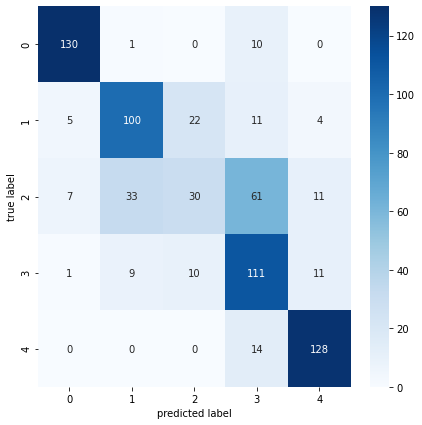

In [661]:
# 모델 평가
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

results = model.predict(X_test)
plt.figure(figsize = (7, 7))
cm = confusion_matrix(np.argmax(y_test, axis = -1), np.argmax(results, axis = -1))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

In [663]:
print(classification_report(np.argmax(y_test, axis = -1), np.argmax(results, axis = -1)))

              precision    recall  f1-score   support

           4       0.91      0.92      0.92       141
           5       0.70      0.70      0.70       142
           6       0.48      0.21      0.29       142
           7       0.54      0.78      0.64       142
           8       0.83      0.90      0.86       142

    accuracy                           0.70       709
   macro avg       0.69      0.70      0.68       709
weighted avg       0.69      0.70      0.68       709



In [679]:
print(X_train.shape)

(6381, 6)


In [689]:
# 학습한 모델로 예측하기
import numpy as np
df_test01 = test[val_list].copy()
df_test01.iloc[:, :5] = scaler.fit_transform(df_test01.iloc[:, :5])
df_test01 = df_test01.to_numpy()
print(df_test01.shape)
result = model.predict(df_test01)
print(result.shape)
arg_result = np.argmax(result, axis = -1)
arg_result

(3231, 6)
(3231, 9)


array([5, 5, 6, ..., 5, 5, 6], dtype=int64)

In [690]:
# 정답파일 작성
predict = pd.read_csv(PATH + '\\sample_submission.csv')
len(predict), len(test)
predict.quality = arg_result
predict.to_csv(PATH + 'sample_submission(NT01).csv', index = False)
pd.read_csv(PATH + 'sample_submission(NT01).csv').head()

,id,quality
0,1,5
1,2,5
2,3,6
3,4,6
4,5,5


In [691]:
# KNN 모델과 다른 값 개수 확인
df1 = pd.read_csv(PATH + 'sample_submission(KNN02).csv')
df2 = pd.read_csv(PATH + 'sample_submission(NT01).csv')
n = 0
for i in range(len(df1)):
    if df1.quality[i] != df2.quality[i]:
        n += 1
n

1732